In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

# Clean and combine data

## Haroon_2018

In [6]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = [i for i in os.listdir('../../Study1/input_data/') if i.startswith('RK')][0]

# Prep responses and key
raw = pd.read_csv('../../Study1/input_data/'+qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('../../Study1/input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

############################################################################################
filter_col = [col for col in raw if col.startswith('Q8.2')]
relationships = pd.read_csv('../../Study1/input_data/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('/',' ') for i in dimensions]

dimension_frames = {}
count=2
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
#     dimension_frames[dim] = fix_df_labels(dimension_frames[dim])
    count=count+1

print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

Total number of responses from qualtrics - 1065
Total number of relationships - 159
Total number of dimensions - 30


In [7]:
# Check color foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q2.1')]
foil_items = foil_items + [x for x in raw.columns.tolist() if x.startswith('Q35.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [s.replace('\xe2\x80\x93', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
filtered_cols = [col for col in raw_reorg if col.startswith(('Q2.1','Q35.1'))]
foils_color_size = pd.DataFrame(responses[filtered_cols])
foils_color_size.columns = foil_items
foils_color_size['MTurkCode']  =raw_reorg['MTurkCode']
foils_color_size = foils_color_size.apply(pd.to_numeric)
"""foils = all_resp_melt.loc[all_resp_melt['word'].isin(['Movie','Fire','Jackpot',
                                                      'Deathbed','Car'])]
foils_melt = all_resp_melt.loc[all_resp_melt['word'].isin(['Movie','Fire','Jackpot',
                                                      'Deathbed','Car'])]"""
foils_color_size_melt = pd.melt(foils_color_size, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_color_size_list = []
for col in foils_color_size.columns[:-1]:
    outliers_color_size_list = outliers_color_size_list + list(foils_color_size[(foils_color_size[col] > 
                   foils_color_size[col].mean()+foils_color_size[col].std()*3.5) |
                   (foils_color_size[col] < 
                    foils_color_size[col].mean()-foils_color_size[col].std()*3.5)].index)
outliers_color_size_list = set(outliers_color_size_list)

# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_color_size_outliers = foils_color_size
foil_color_size_outliers = foil_color_size_outliers[~foil_color_size_outliers.index.isin(outliers_color_size_list)]
foil_color_size_outliers_melt = pd.melt(foil_color_size_outliers, id_vars='MTurkCode')

# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q34')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q34.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_relationships = [i.split(' - ', 1)[1] for i in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q34.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['MTurkCode']  =raw_reorg['MTurkCode']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)

# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='MTurkCode')

# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['MTurkCode'] = raw_reorg['MTurkCode']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='MTurkCode')

# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

################################################################################
# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_color_size_list) + list(familiarity_list))
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Haroon_dict = dimension_frames_outliers

Total number of responses, excluding bad participants - 817
Smallest number of ratings for a relationship - 4
Largest number of ratings for a relationship - 30


In [8]:
result_dict = Haroon_dict
with pd.ExcelWriter('output_data/dict_results/usa_round1.xlsx') as writer:
    for dim in result_dict.keys():
        temp_df = result_dict[dim]
        temp_df.columns = relationships
        temp_df.to_excel(writer,sheet_name = dim)

In [4]:
familiarity_outlier = familiarity[~familiarity.index.isin(outliers_all_list)]
familiarity_haroon = familiarity_outlier.iloc[:,:-1]

## Huanqing_2022

In [2]:
dimension_33d = pd.read_csv('../../Study3/DataCleanPCA/input_data/RelDim_labels/dimensions_33d.csv',index_col=0)
dimension_33d = dimension_33d.iloc[:,0].to_list() 

relationships = pd.read_csv('../../Study3/DataCleanPCA/input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

In [3]:
# version1
raw_v1 = pd.read_csv('../../Study3/DataCleanPCA/input_data/Nations/US/SR_US1_Mturk.csv',encoding='UTF-8')
raw_v1_reorg = raw_v1.drop(axis='index',index=[0,1])
raw_v1_reorg['subject'] = list(raw_v1_reorg.index)
raw_v1_reorg = raw_v1_reorg.reset_index(drop=True)
raw_v1_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v1_reorg['Duration (in seconds)'])

response_v1 = raw_v1_reorg
response_v1['subject'] = list(raw_v1_reorg.index)
response_v1 = response_v1.loc[:, response_v1.columns.str.startswith('Q')]

# version2
raw_v2 = pd.read_csv('../../Study3/DataCleanPCA/input_data/Nations/US/SR_US2_Mturk.csv',encoding='UTF-8')
raw_v2_reorg = raw_v2.drop(axis='index',index=[0,1])
raw_v2_reorg['subject'] = list(raw_v2_reorg.index)
raw_v2_reorg = raw_v2_reorg.reset_index(drop=True)
raw_v2_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v2_reorg['Duration (in seconds)'])

response_v2 = raw_v2_reorg
response_v2['subject'] = list(raw_v2_reorg.index)
response_v2 = response_v2.loc[:, response_v2.columns.str.startswith('Q')]

# version3
raw_v3 = pd.read_csv('../../Study3/DataCleanPCA/input_data/Nations/US/SR_US3_Mturk_220627.csv',encoding='UTF-8')
raw_v3_reorg = raw_v3.drop(axis='index',index=[0,1])
raw_v3_reorg['subject'] = list(raw_v3_reorg.index)
raw_v3_reorg = raw_v3_reorg.reset_index(drop=True)
raw_v3_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v3_reorg['Duration (in seconds)'])

response_v3 = raw_v3_reorg
response_v3['subject'] = list(raw_v3_reorg.index)
response_v3 = response_v3.loc[:, response_v3.columns.str.startswith('Q')]

# combine all versions
raw_reorg_qualtrics = pd.concat([raw_v1_reorg,raw_v2_reorg,raw_v3_reorg])
responses_qualtrics = pd.concat([response_v1,response_v2,response_v3])
responses_qualtrics = responses_qualtrics.reset_index(drop=True)
# Get total number of response
print("Total number of response from qualtrics - "+str(len(responses_qualtrics)))

#####################################################################################
# Check rel foils to exclude people
filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q39','Q40'))]
foil_items = raw_v1[filtered_cols].iloc[0]
foil_items = [s.replace(' 鈥?', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
foil_items = [i.replace('Victim-Criminal','Victim and Criminal') for i in foil_items]
foil_items = [i.replace('Driver - Passenger','Driver and Passenger') for i in foil_items]
foil_items = [i.replace('Parent-Infant','Parent and Infant') for i in foil_items]

foils_rel_size = pd.DataFrame(responses_qualtrics[filtered_cols])
foils_rel_size.columns = foil_items
foils_rel_size = foils_rel_size.reset_index(drop = True) # after combing all versions, reset index
foils_rel_size = foils_rel_size.apply(pd.to_numeric)

foils_rel_size_new = pd.DataFrame(columns = foils_rel_size.columns.unique())
for col in foils_rel_size.columns.unique().to_list():
    foils_list = []
    foils_df = foils_rel_size[col]
    for i in foils_df.index.to_list():
        foils = foils_df.loc[i,:].dropna().values[0]
        foils_list.append(foils)
    foils_rel_size_new[col] = foils_list
foils_rel_size = foils_rel_size_new

filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q0'))]
familiarity = pd.DataFrame(raw_reorg_qualtrics[filtered_cols])
familiarity.columns = relationships
familiarity = familiarity.reset_index(drop = True) # after combing all versions, reset index
#familiarity['subject'] = raw_reorg_qualtrics['subject']
familiarity = familiarity.apply(pd.to_numeric)

#dim_comprehension
count = 4
filtered_dim_com = []
while count <= 38:
    [filtered_dim_com.append(col) for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.1')]
    if count == 33 or count == 36:
        count += 2
    else:
        count += 1
response_dim_com = responses_qualtrics[filtered_dim_com]
                     
dimension_frames = {}
count=4
for dim in dimension_33d: 
    if count == 34 or count == 37:
        count = count + 1
    filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses_qualtrics[filtered_cols])
    dimension_frames[dim].columns = relationships
    count=count+1
    
# foils_rel_size_qualtrics = foils_rel_size
# familiarity_qualtrics = familiarity
# response_dim_com_qualtrics = response_dim_com

Total number of response from qualtrics - 629


C:\Users\DELL\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\DELL\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\DELL\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\DELL\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total number of responses, excluding bad participants - 567
Smallest number of ratings for a relationship - 5
Largest number of ratings for a relationship - 15


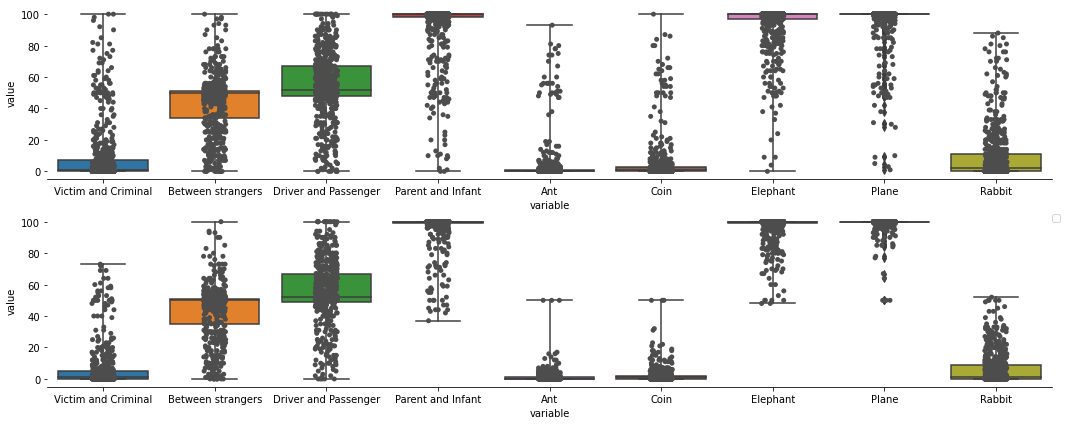

In [4]:
std = 3.5
foils_rel_size['subject'] = foils_rel_size.index.to_list()
foils_rel_size = foils_rel_size.apply(pd.to_numeric)
foils_rel_size_melt = pd.melt(foils_rel_size, id_vars='subject')
foils_rel_size_melt.columns = ['subject','variable','value']
outliers_rel_size_list = []
for col in foils_rel_size.columns[:-1]:
    outliers_rel_size_list = outliers_rel_size_list + list(foils_rel_size[(foils_rel_size[col] > 
                   foils_rel_size[col].mean()+foils_rel_size[col].std()*std) |
                   (foils_rel_size[col] < 
                    foils_rel_size[col].mean()-foils_rel_size[col].std()*std)].index)
outliers_rel_size_list = set(outliers_rel_size_list)

foil_rel_size_outliers = foils_rel_size
foil_rel_size_outliers = foil_rel_size_outliers[~foil_rel_size_outliers.index.isin(outliers_rel_size_list)]
foil_rel_size_outliers_melt = pd.melt(foil_rel_size_outliers, id_vars='subject')
foil_rel_size_outliers_melt.columns = ['subject','variable','value']

f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_rel_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_rel_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_rel_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_rel_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


#check familiarity
familiarity['subject'] = familiarity.index.to_list()
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='subject')

#Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] > 
                   familiarity[col].mean()+familiarity[col].std()*3.5) |
                   (familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

#remove outliers from original data
outliers_all_list = set(list(outliers_rel_size_list) + list(familiarity_list))
outliers_all_list_df = pd.DataFrame(outliers_all_list)
outliers_all_list_df.to_csv('output_data/outlier_df/USA_2022.csv')

dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

#Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimension_33d)
for dim in dimension_33d:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 
#

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))


Huanqing_dict = dimension_frames_outliers

In [5]:
result_dict = Huanqing_dict
with pd.ExcelWriter('output_data/dict_results/usa_round2.xlsx') as writer:
    for dim in result_dict.keys():
        temp_df = result_dict[dim]
        temp_df.columns = relationships
        temp_df.to_excel(writer,sheet_name = dim)

In [8]:
familiarity_outlier = familiarity[~familiarity.index.isin(outliers_all_list)]
familiarity_huanqing = familiarity_outlier.iloc[:,:-1]

In [9]:
familiarity_159rels = pd.concat([familiarity_haroon,familiarity_huanqing])
familiarity_159rels.to_csv('output_data/familiarity/familiarity_159rels_usa_2rounds.csv')

## combine

In [10]:
USA_2rounds_dict = {}
dimensions_33d = pd.read_csv('../DataCleanPCA/input_data/RelDim_labels/dimensions_33d.csv',index_col=0)
dimensions_33d = dimensions_33d.iloc[:,0].to_list()
for dim in dimensions_33d:
    if dim not in ['Morality','Trust','Generation Gap']:
        Haroon_df = Haroon_dict[dim]
    
    Huanqing_df = Huanqing_dict[dim]
    
    USA_2rounds_df = pd.concat([Haroon_df,Huanqing_df])
    USA_2rounds_dict[dim] = USA_2rounds_df

In [11]:
result_dict = USA_2rounds_dict
with pd.ExcelWriter('output_data/dict_results/USA_tworounds.xlsx') as writer:
    for dim in result_dict.keys():
        result_dict[dim].to_excel(writer,sheet_name = dim)

# Dim_rel(scaled)

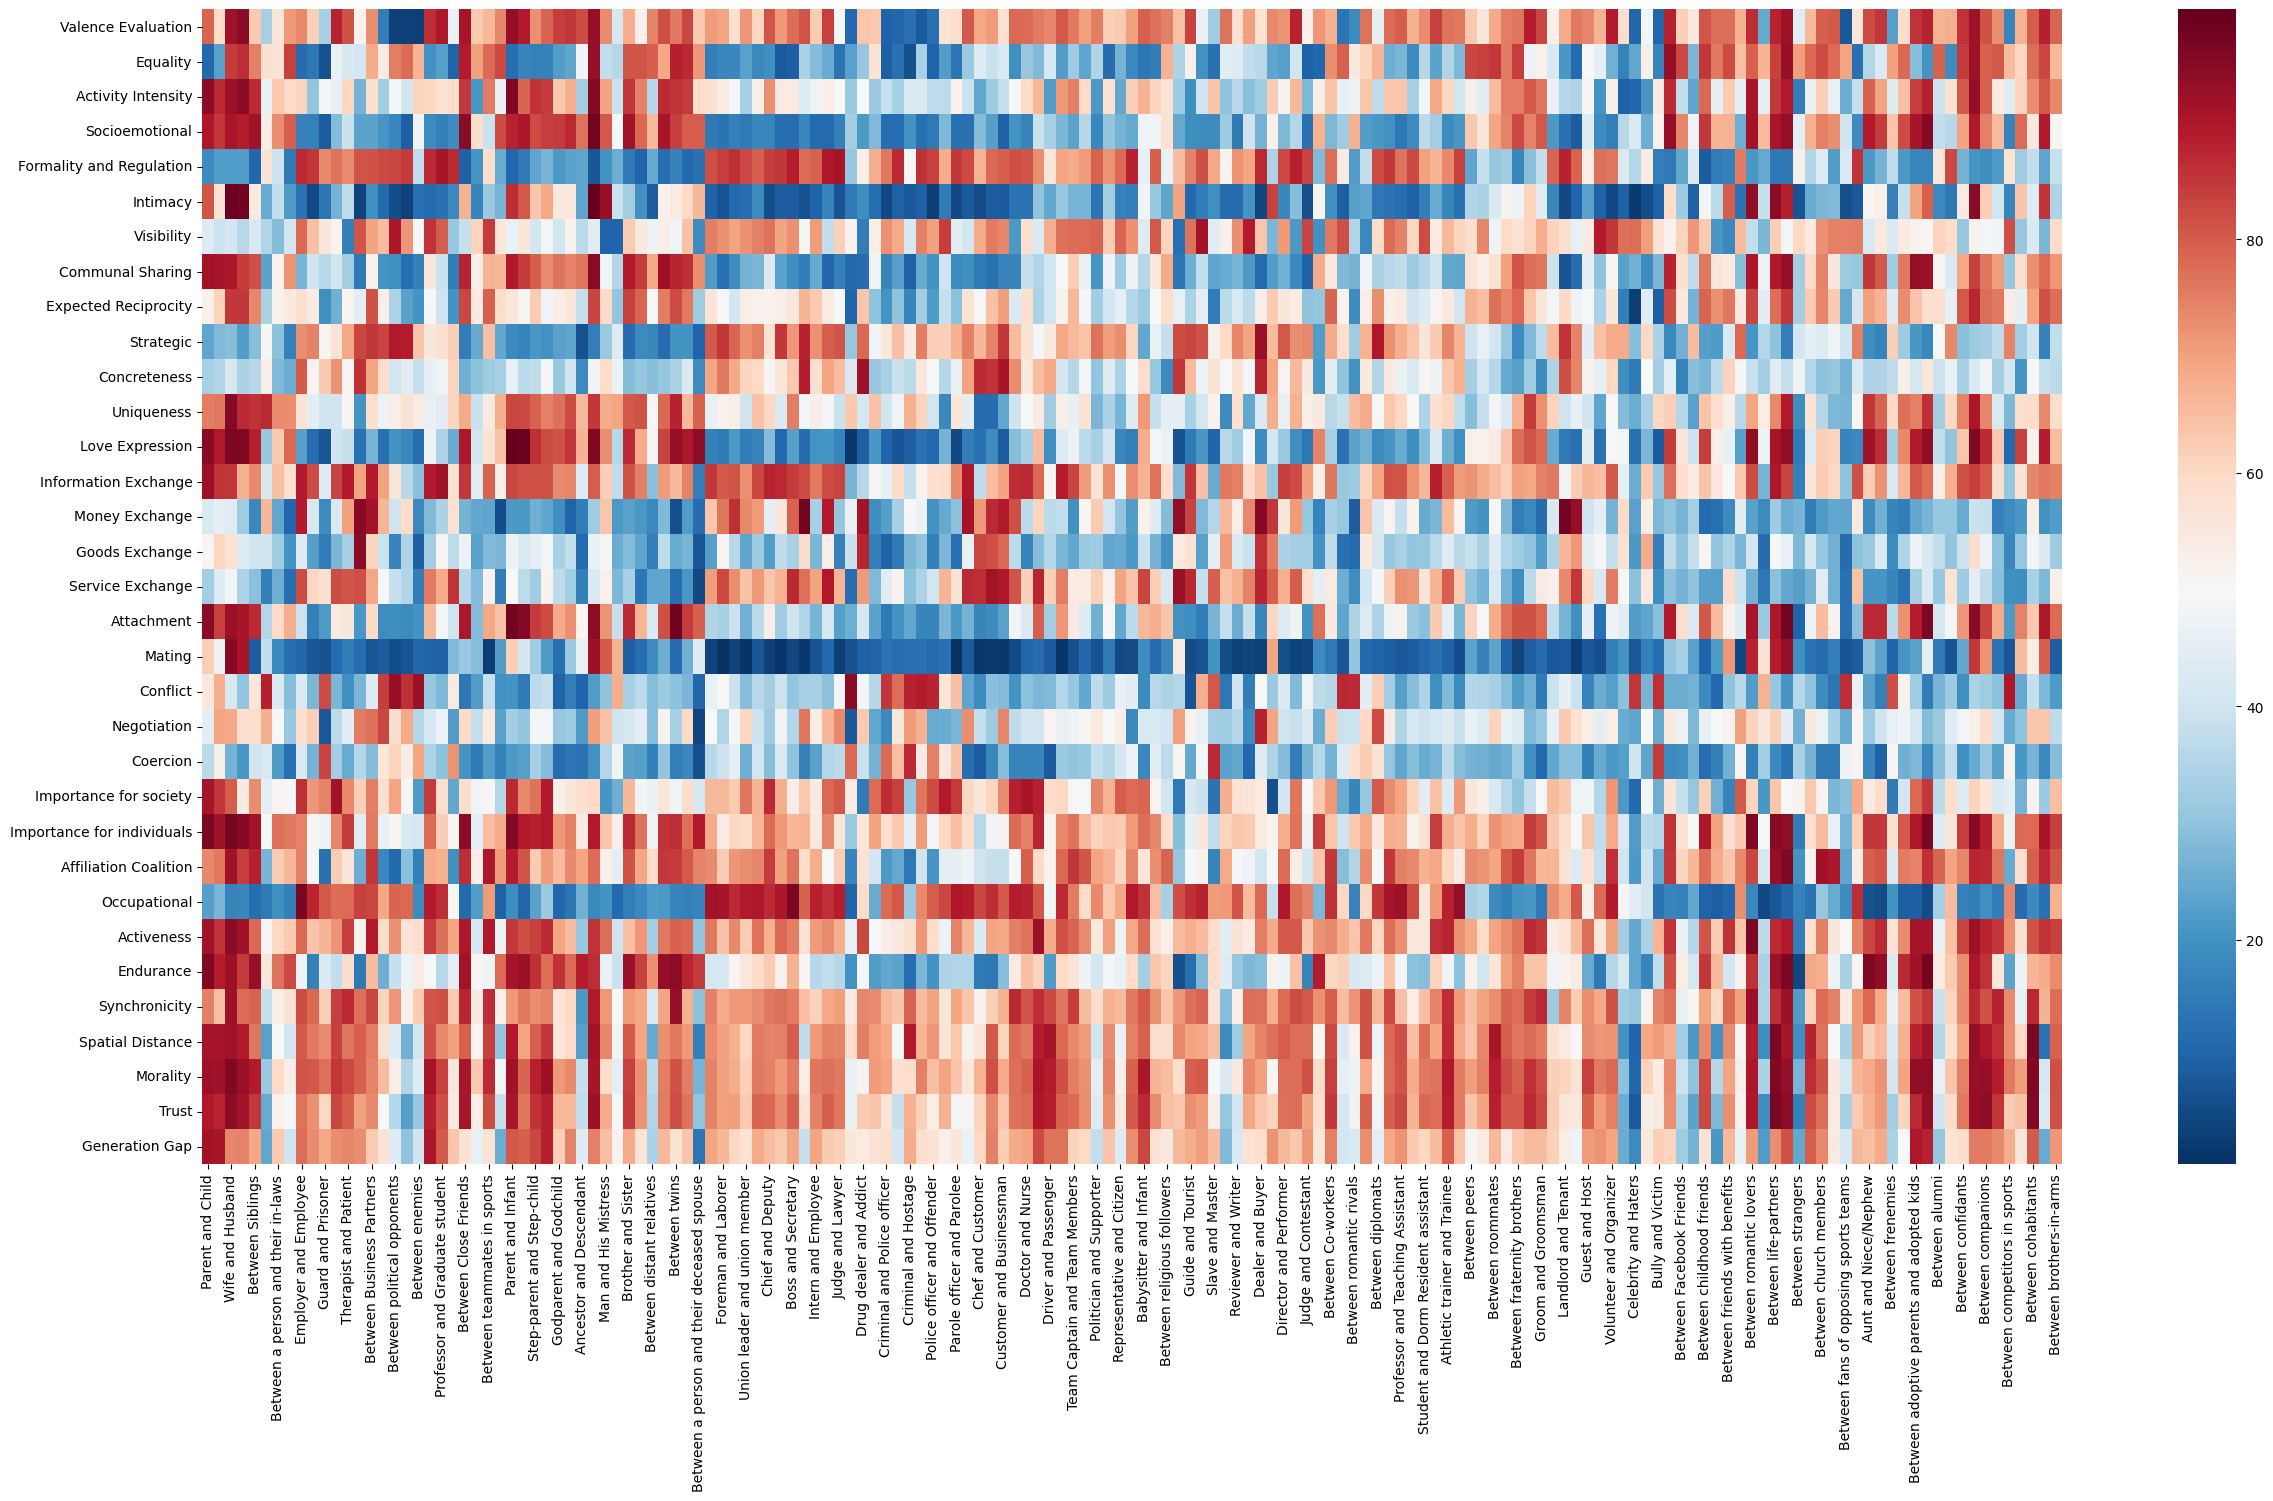

In [12]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions_33d:
    dim_rel.loc[count] = USA_2rounds_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions_33d
dim_rel.to_csv('output_data/cleaning_results/USA/USA_combine_dim_rel_33d.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=dim_rel.columns,columns=dim_rel.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/USA/USA_combine_dim_rel_scaled_33d.csv')

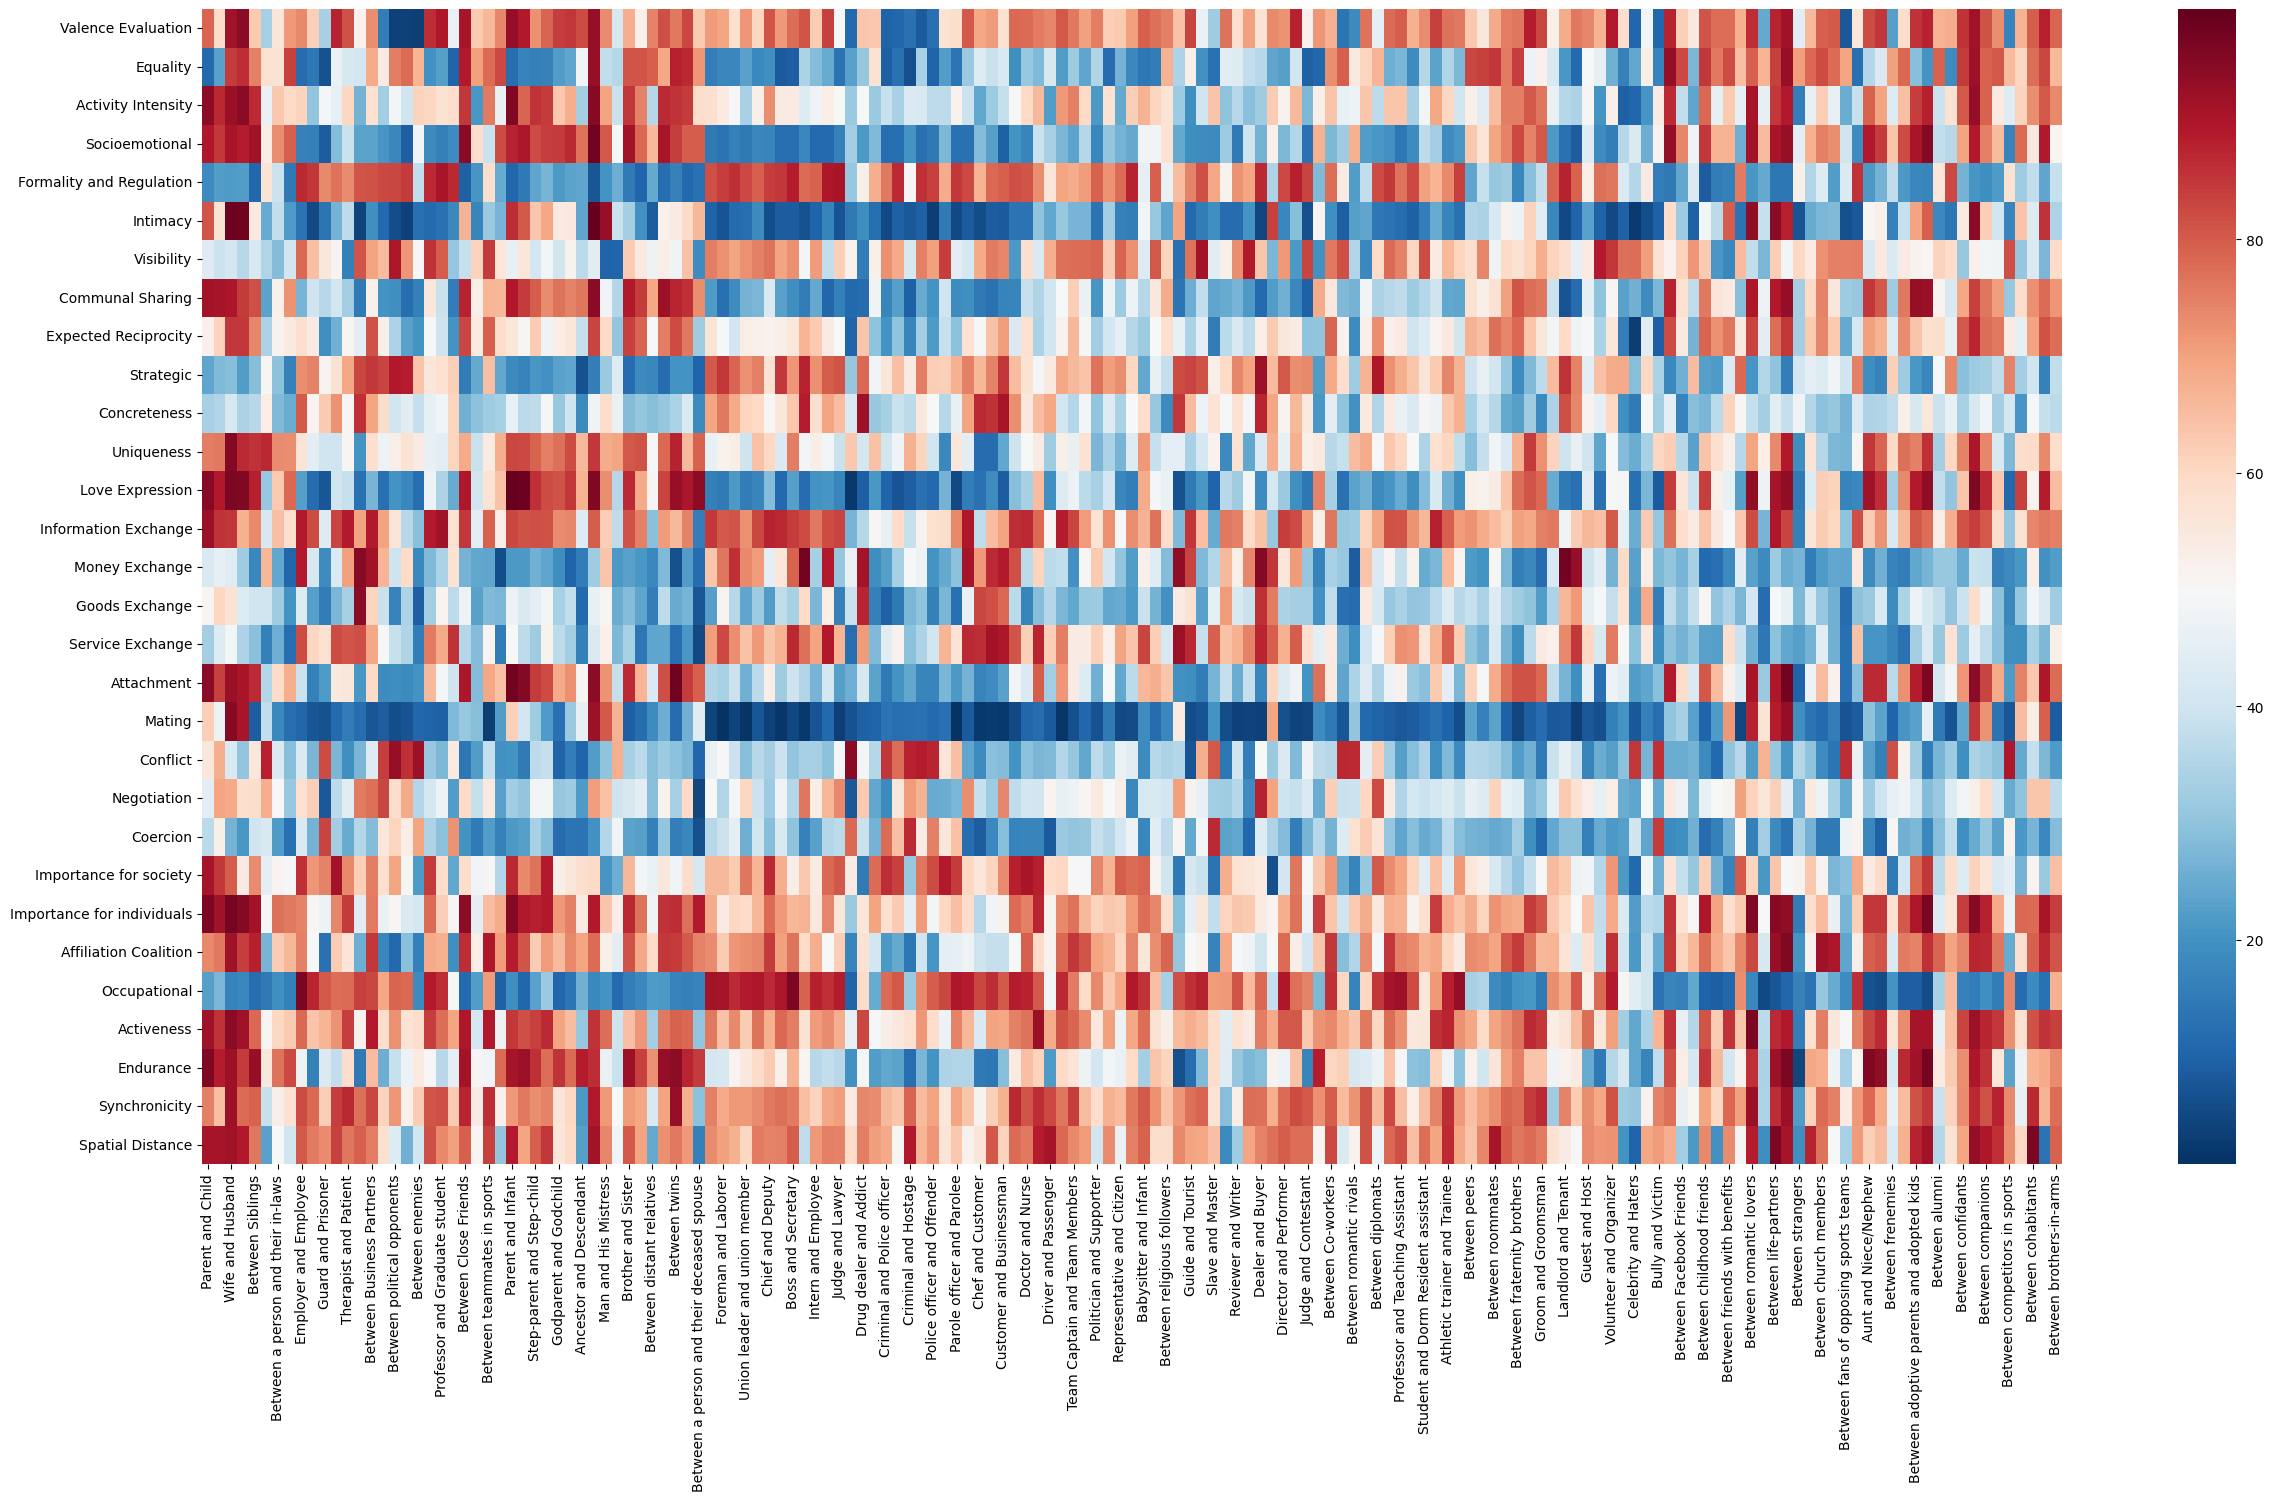

In [13]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions_33d[0:30]:
    dim_rel.loc[count] = USA_2rounds_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions_33d[0:30]
dim_rel.to_csv('output_data/cleaning_results/USA/USA_combine_dim_rel_30d.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=dim_rel.columns,columns=dim_rel.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/USA/USA_combine_dim_rel_scaled_30d.csv')

# PCA

In [5]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)

library(ggplot2)
library(corrplot)
library(RColorBrewer)

library(tidyverse)
library(reshape)#melt6
library(nFactors)#optimal number of components

## 159rel×33d


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.245  0.368  0.831  0.179       
Equality                   -0.337 -0.138  0.177 -0.214 -0.790
Activity.Intensity         -0.634  0.637  0.173 -0.152       
Socioemotional             -0.840         0.273 -0.317 -0.233
Formality.and.Regulation    0.836  0.107 -0.131  0.315  0.261
Intimacy                   -0.859  0.292  0.203        -0.122
Visibility                  0.759  0.142        -0.289 -0.147
Communal.Sharing           -0.662  0.296  0.403 -0.444 -0.231
Expected.Reciprocity       -0.314  0.410  0.490        -0.605
Strategic                   0.787        -0.212  0.468       
Concreteness                0.328  0.196         0.809  0.128
Uniqueness                 -0.738  0.353        -0.128       
Love.Expression            -0.760  0.239  0.452 -0.286 -0.126
Information.Exchange        0.107  0.714  0.497              
Money.Exchange              0.341                0.850     

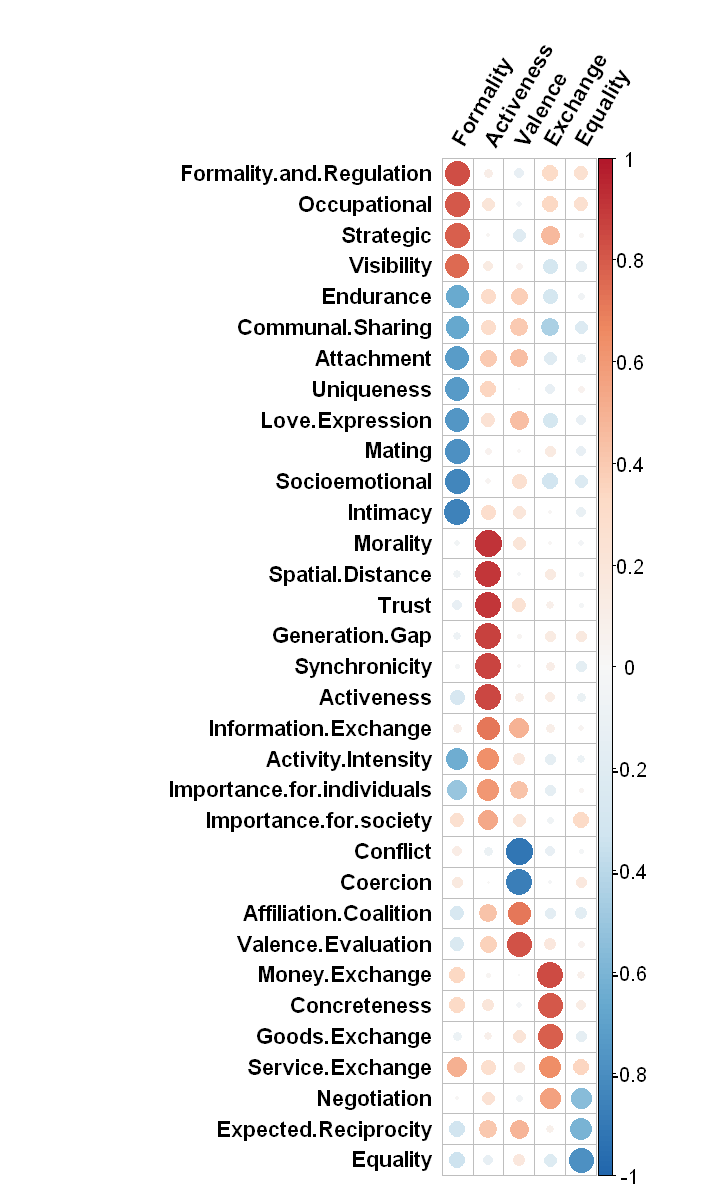

In [3]:
dim_rel_scaled = read.csv('output_data/cleaning_results/USA/USA_combine_dim_rel_scaled_33d.csv',
                          row.names=1,encoding='UTF-8')
# rownames(dim_rel_scaled) <- fix_label(rownames(dim_rel_scaled))

dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/USA/USA_loadings_var_33d.csv')
write.csv(scores_var,'output_data/pca_results/USA/USA_scores_var_33d.csv')

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Exchange','Equality')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(Valence)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 159rel×30d


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.228  0.361  0.842  0.169       
Equality                   -0.288         0.181 -0.263 -0.797
Activity.Intensity         -0.586  0.701  0.170 -0.184       
Socioemotional             -0.795         0.300 -0.386 -0.257
Formality.and.Regulation    0.800        -0.166  0.387  0.291
Intimacy                   -0.840  0.314  0.230        -0.144
Visibility                  0.789  0.107        -0.220 -0.112
Communal.Sharing           -0.595  0.334  0.418 -0.490 -0.237
Expected.Reciprocity       -0.265  0.463  0.486        -0.601
Strategic                   0.745        -0.243  0.527       
Concreteness                0.258  0.142         0.845  0.127
Uniqueness                 -0.707  0.435        -0.181       
Love.Expression            -0.708  0.283  0.467 -0.342 -0.138
Information.Exchange        0.138  0.748  0.472  0.126       
Money.Exchange              0.273                0.872     

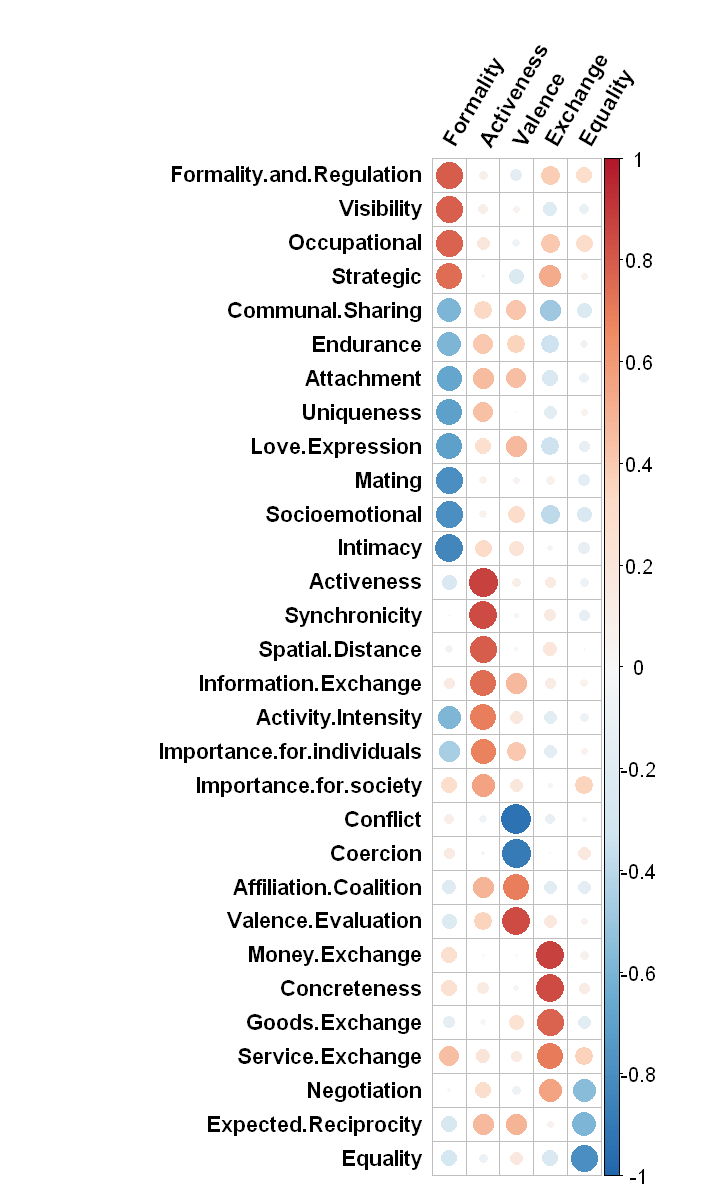

In [7]:
dim_rel_scaled = read.csv('output_data/cleaning_results/USA/USA_combine_dim_rel_scaled_30d.csv',
                          row.names=1,encoding='UTF-8')
# rownames(dim_rel_scaled) <- fix_label(rownames(dim_rel_scaled))

dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/USA/USA_loadings_var_30d.csv')
write.csv(scores_var,'output_data/pca_results/USA/USA_scores_var_30d.csv')

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Exchange','Equality')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(Valence)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))